# Projekt 1 – perceptron Rosenblatta

## Temat: płytka sieć do nauki problemu XOR

## Tasks:
### Waiting

* Wykresy błędu MSE (błędu średniokwadratowego) w obu warstwach (na przykładach uczących oraz na całym zbiorze uczącym):

    - dla całego ciągu uczącego 


* Dodać opisy zdjęć - skąd są




### In progres


### Ready

* ujednolicić nazwy zmiennych
* nazwa dla learn
* Opis zaimplementowanych funkcji - dopieścić
* Opis zaimplementowanych zmiennych i stałych - eze

### Done
* Zaimplelentować mini - batche 
* Wykresy błędu MSE    - dla warstwy ukrytej MSE
* Wykresy błędu MSE - dla przykładu uczącego
* szybsze kończenie uczenia przy spadku MSE poniżej zadanej wartości
* wykresy błędu klasyfikacji
* wykresy błędu klasyfikacji (przyjmujemy próg 0.5 dla klasyfikacji 0-1)
* Krótki opis problemu
* wykresy wag w obu warstwach.


<!-- ### To do - jak wystarczy czasu - pewnie nie wystarczy:

* dodanie momentum,
* adaptacyjny współczynnik uczenia, -->


## Część teoretyczna


### Opis Problemu - MLP for XOR problem
Problem XOR (Exclusive OR) stanowi kluczowy problem w uczeniu maszynowym, który ilustruje wyzwania związane z tworzeniem modeli opartych na neuronach lub sieciach neuronowych.

XOR to logiczna operacja, która zwraca prawdę (1) tylko wtedy, gdy jedno z wejść jest prawdziwe, a drugie fałszywe.

![Bramka XOR](./photos/XOR_tabela_prawdy.png )
 
*Zdj. 1. Tabela prawdy dla XOR - źródło https://towardsdatascience.com/how-neural-networks-solve-the-xor-problem-59763136bdd7*


Problem polega na tym, że XOR nie jest liniowo separowalny - oznacza to, że nie można podzielić przestrzeni wejść linią (linią prostą w dwóch wymiarach lub płaszczyzną w trzech wymiarach), aby poprawnie oddzielić przypadki prawdziwe od fałszywych.

![Przestrzeń cech XOR](./photos/XOR_przestrzen_wejsc.png)

*Zdj. 2. Wykres wyjść dla XOR - źródło https://towardsdatascience.com/how-neural-networks-solve-the-xor-problem-59763136bdd7*



Tradycyjne modele liniowe, takie jak regresja logistyczna czy perceptron, nie są w stanie modelować funkcji XOR, ponieważ nie mogą stworzyć odpowiedniego podziału przestrzeni wejść. Jednak sieci neuronowe z warstwą ukrytą potrafią rozwiązać ten problem poprzez tworzenie nieliniowych kombinacji wejść. Wprowadzenie warstwy ukrytej pozwala na stworzenie odpowiednich granic decyzyjnych w przestrzeni cech, umożliwiając modelowi na nauczenie się funkcji XOR.

![Rozwiązanie XOR za pomocą MLP](./photos/rozw_problemuXOR_MLP.png)

*Zdj. 3. Poprawny sposób klasyfikacji wyjść dla XOR - źródło https://towardsdatascience.com/how-neural-networks-solve-the-xor-problem-59763136bdd7*


W celu sprawnego nauczenia sieci i przedstawienia skondensowanych wyników, sieć domyślnie jest uczona 4 przypadków jednocześnie, tj zbierane są gradienty dla każdego przypdadku wejścia XOR i zmiany dW1, db1, dW2, db2 są wszystkie nakładane jednocześnie.  

## Implementacja sieci

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

In [2]:
now = datetime.now().second # trochę bardziej losowe generowanie seeda
np.random.seed(now) # on był pseudo losowy celowo XD

In [3]:
# funckja get_data_batch
# na podstawie zadanej wielkości zwraca przykłąd uczący o zadanej wielkości
#
# Opis przyjmowenych zmiennych:
#   X             -   ciąg uczący X lub zwrócona wcześniej zmienna X
#   Y             -   ciąg uczący Y lub zwrócona wcześniej zmienna Y
#   batch         -   zadana wielkość przykłądu uczącego
#
# Opis zwracanych zmiennych
#   X             - pomocnicza zmienna X, należy przekazać do funkcji w kolejnej iteracji
#   Y             - pomocnicza zmienna Y, należy przekazać do funkcji w kolejnej iteracji
#   np.array(X_)  - przykład uczący X o zadanej wielkości batch
#   np.array(Y_)  - przykład uczący Y o zadanej wielkości batch

def get_data_batch(X,Y,batch):
    X_ = []
    Y_ = []
    for _ in range(0,batch):
        X_.append(X[0])
        X = np.delete(X,0,0)
        if len(X) == 0:
            X = np.array([[0,0],[0,1],[1,0],[1,1]])
        Y_.append(Y[0])
        Y = np.delete(Y,0,0)
        if len(Y) == 0:
            Y = np.array([[0],[1],[1],[0]])
    
    return X, Y, np.array(X_),np.array(Y_)


Funkcja aktywacji i jej pochodna 

In [4]:
# funkcja sigmoid
# funkcja aktywacji używana dla każdego neuronu
def sigmoid(x): 
	return 1.0/(1.0 + np.exp(-x))

# funkcja sigmoid_prime
# pochodna funkcji aktywacji używana przy obliczaniu wag w propagacji wstecznej
def sigmoid_prime(x): 
    return x * (1 - x)

Parametry poczatkowe - wagi i bajasy

In [5]:
# funckja initialize_params
# inicjalizacja wag i baiasów w sposób losowy o wartościach od -0.5 do 0.5
# wartości losowe aby przełamać symetrie 
#
# Opis zwracanych zmiennych
#   W1            - wagi początkowe dla 1. warstwy sieci
#   b1            - bajasy początkowe dla 1. warstwy sieci
#   W2            - wagi początkowe dla 2. warstwy sieci
#   b2            - bajasy początkowe dla 2. warstwy sieci

def initialize_params():
    W1 = np.random.rand(2, 2) - 0.5
    b1 = np.random.rand(1, 2) - 0.5
    W2 = np.random.rand(2, 1) - 0.5
    b2 = np.random.rand(1, 1) - 0.5
    return W1, b1, W2, b2


In [6]:
# funkcja forward_prop
# oblicza wartości wyjściowe implementowanej sieci
#
# Opis przyjmowenych zmiennych:
#   W1            - macierz wag 1. warstwy szkolonej sieci
#   b1            - macierz bajasów 1. warstwy szkolonej sieci
#   W2            - macierz wag 2. warstwy szkolonej sieci
#   b2            - macierz bajasów 2. warstwy szkolonej sieci
#   X             - przykład uczący - wartości wejściowe
#
# Opis zwracanych zmiennych:
#   A1            - wyjście 1. warstwy 
#   A2            - wyjscie 2. wartości 

def forward_prop(W1, b1, W2, b2, X):
    # 1. warstwa
    Z1 = np.dot(X,W1) + b1 # przemnożenie przez wagi i dodanie bajasów 
    A1 = sigmoid(Z1) # funkcja aktywacji
    
    # 2. warstwa
    Z2 = np.dot(A1,W2) + b2 # przemnożenie przez wagi i dodanie bajasów 
    A2 = sigmoid(Z2) # funkcja aktywacji
    
    return A1, A2

 
# funkcja backward_prop
# propagacja wsteczna, potrzebna do wyznaczenia wartości gradientu, błędu i poprawek
#
# Opis przyjmowenych zmiennych:
#   A1            - wyjście 1. warstwy 
#   A2            - wyjscie 2. wartości 
#   W2            - macierz wag 2. warstwy szkolonej sieci
#   Y             - przykład uczący - wartości oczekiwane
#
# Opis zwracanych zmiennych:
#   dA1           - błąd 1. warstwy
#   dZ1           - błędy neuronów 1. warstwy
#   dA2           - błąd 2. warstwy
#   dZ2           - błędy neuronów 2. warstwy

def backward_prop(A1, A2, W2, Y): 
    dA2 = Y - A2 # błąd 2. warstwy
    dZ2 = dA2 * sigmoid_prime(A2) # błędy neuronów 2. warstwy
    
    dA1 = dZ2.dot(W2.T) # błąd 1. warstwy
    dZ1 = dA1 * sigmoid_prime(A1) # błędy neuronów w 1. warstwy

    return dA2, dZ2, dA1, dZ1

# funkcja calculate_corrections
# oblicza poprawki wag i bajasów sieci
#
# Opis przyjmowenych zmiennych:
#   X             - przykład uczący - wartości wejściowe
#   A1            - wyjście 1. warstwy 
#   dZ1           - błędy neuronów 1. warstwy
#   dZ2           - błędy neuronów 2. warstwy
#   lr            - współczynnik uczenia
#
# Opis zwracanych zmiennych:
#   dW1           - zmiana dla wag 1. warstwy
#   db1           - zmiana dla bajasów 1. warstwy
#   dW2           - zmiana dla wag 2. warstwy
#   db2           - zmiana dla bajasów 2. warstwy

def calculate_corrections(X, A1, dZ1, dZ2, lr):
    dW1 = lr * X.T.dot(dZ1)
    db1 = lr * np.sum(dZ1,axis=0,keepdims=True)
    
    dW2 = lr * A1.T.dot(dZ2) 
    db2 = lr * np.sum(dZ2,axis=0,keepdims=True)

    return dW1, db1, dW2, db2


In [7]:
# funkcja classification_error
# zwraca błąd klasyfikacji - gdzie próg klasyfikacji to 0.5
#
# Opis przyjmowenych zmiennych:
#   Y             - przykład uczący - wartości oczekiwane
#   A2            - wyjscie 2. wartości 
#
# Opis zwracanych zmiennych:
#   błąd klasyfkiacji

def classification_error(Y,A2):
    C = np.abs(Y - A2) > 0.5
    return C.sum()/Y.size

# def calculate_mse(dA2):

In [8]:
# funkcja learn
# realizuje Mini-Batch Gradient Descent, istnieje możliwość zadania wielkosci batcha
# Opis przyjmowenych zmiennych:
#   X             -   ciąg uczący
#   Y             -   ciąg uczący, odpowiedzi oczekiwane
#   iterations    -   maksymalna ilość iteracji
#   logs          -   czy funkcjia ma zwracać logi co 1000 iteracji
#   batch_size    -   rozmiar wchodzącego przykładu uczącego
#   mse_threshold -  przy jakim błędzie mse ma zostać zakończone uczenie
#
# Opis zwracanych zmiennych:
#   W1            - wagi 1. warstwy wyszkolonej sieci
#   b1            - bajasy 1. warstwy wyszkolonej sieci
#   W2            - wagi 2. warstwy wyszkolonej sieci
#   b2            - bajasy 2. warstwy wyszkolonej sieci
#   CE            - tablica błędu klasyfikacji
#   MSE1          - MSE - błąd średniokwadratowy 2. warstwy dla przykładu uczącego
#   MSE2          - tablica MSE - błąd średniokwadratowy 2. warstwy dla przykładu uczącego
#   Ws1           - tablica wag 1. warstwy
#   bs1           - tablica bajasów 1. warstwy
#   Ws2           - tablica wag 2. warstwy
#   bs2           - tablica bajasów 2. warstwy

def learn(X, Y, lr, iterations, logs = True, batch_size = 2, mse_threshold = 0.005):
    W1, b1, W2, b2 = initialize_params()    # funkcja zwraca losowe początkowe wagi i bajasy używane w sieci
    CE = []     # classification error - procent błędnych klasyfikacji
    MSE2 = []   # MSE - błąd średniokwadratowy 2. warstwy dla przykładu uczącego
    MSE1 = []   # MSE - błąd średniokwadratowy 1. warstwy dla przykładu uczącego
    Ws1 = [W1]  # Wagi 1. warstwy
    bs1 = [b1]  # Bajasy 1. warstwy
    Ws2 = [W2]  # Wagi 2. warstwy
    bs2 = [b2]  # Bajasy 2. warstwy
    Xcu = X     # Ciąg uczący X
    Ycu = Y     # Ciąg uczący Y
    
    for i in range(iterations):
        Xcu, Ycu, X,Y = get_data_batch(Xcu,Ycu,batch_size) # wyznaczenie przykłądu uczącego zgodnie z zadaną wielkością batch_size
        A1, A2 = forward_prop(W1, b1, W2, b2, X) # propagacja - wyliczenie wartości wyjściowych obu warstw 

        dA2, dZ2, dA1, dZ1 = backward_prop(A1, A2, W2, Y)  # propagacja wsteczna
        
        dW1, db1, dW2, db2 = calculate_corrections(X, A1, dZ1, dZ2, lr) # wyliczenie poprawek dla wag i bajasów 
        
        # Obliczanie błędu średniokwadratowego dla przykładu uczącego
        MSE2_current = np.mean(dA2 ** 2)
        MSE2.append(MSE2_current)
        MSE1.append(np.mean(dA1 ** 2))
        
        # Aktualizacja wag i bajasów
        W1 = W1 + dW1
        b1 = b1 + db1 
        W2 = W2 + dW2 
        b2 = b2 + db2
        
        # Zebranie parametrów sieci w celu wizualizacji
        Ws1.append(W1)
        bs1.append(b1)
        Ws2.append(W2)
        bs2.append(b2)
        
        # Obliczenie i zapamiętanie błędu klasyfikacji dla przykładu uczącego 
        CE.append(classification_error(Y,A2))
        
        # Co 1000 iteracji zostają wypisane wartości wyjściowe sieci zestawione z wartościami oczekiwanymi
        if i % 1000 == 0 and logs:
            print("Iteration: ", i)
            print(A2.T)
            print(Y.T)
            
        # Uczenie zostanie przerwane kiedy MSE spadnie poniżej zadanego progu
        if MSE2_current <= mse_threshold:
            break
        
    # wypisanie ostatecznych wartości wyjściowych zestawionych z wartościami oczekiwanymi
    print("Final Predictions")
    print(A2.T)
    print(Y.T)
    return W1, b1, W2, b2, CE, MSE1, MSE2, Ws1, bs1, Ws2, bs2

Ciąg danych uczących:

In [9]:
X = np.array([[0,0],[0,1],[1,0],[1,1]])
Y = np.array([[0],[1],[1],[0]])     

Wywołanie funkcji learn zaimplementowanej sieci:

In [10]:

W1, b1, W2, b2, CE, MSE1, MSE2, Ws1, bs1, Ws2, bs2 = learn(X, Y, 0.2, 30000, logs = False, batch_size = 2, mse_threshold = 0.005)

Final Predictions
[[0.06494091 0.92395967]]
[[0 1]]


## Wizualizacje

### Błąd klasyfikacji CE

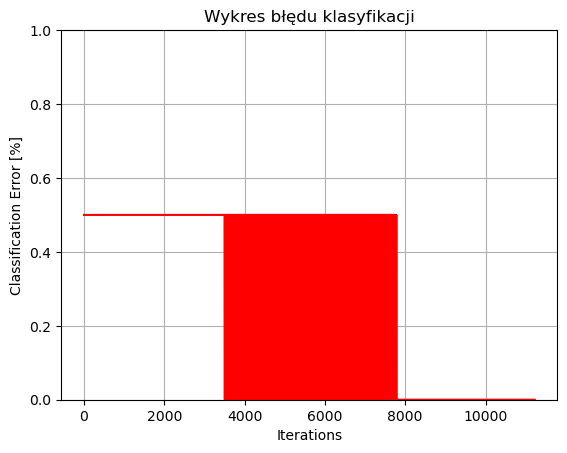

In [11]:
plt.plot(CE,'r')
plt.xlabel('Iterations')
plt.ylabel('Classification Error [%]')
plt.ylim([0, 1])
plt.title('Wykres błędu klasyfikacji')
plt.grid(True)
plt.show()

### Błąd średniokwadratowy MSE

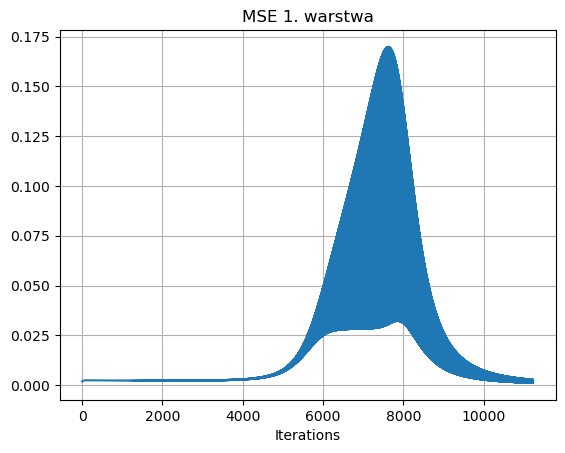

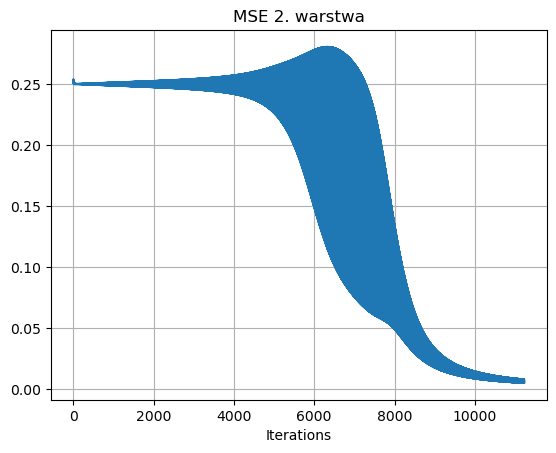

In [12]:
plt.plot(MSE1)

plt.xlabel('Iterations')
plt.ylabel('')
plt.title('MSE 1. warstwa')
plt.grid(True)
plt.show()

plt.plot(MSE2)

plt.xlabel('Iterations')
plt.ylabel('')
plt.title('MSE 2. warstwa')
plt.grid(True)
plt.show()


### Wagi i bajasy

Wykresy dla 1 warstwy

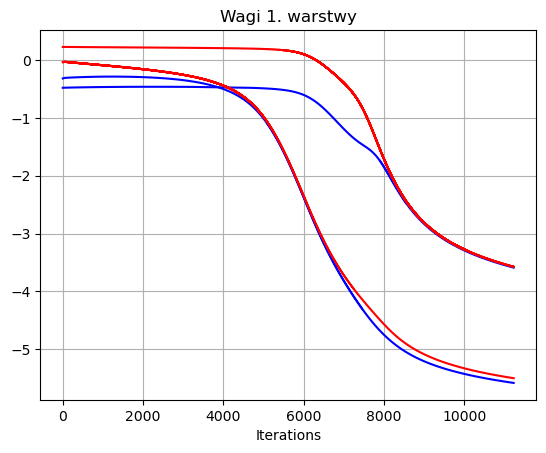

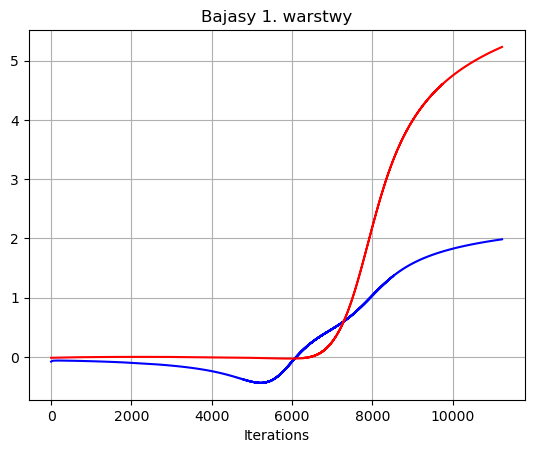

In [13]:
plt.plot([Ws1[n][0]for n in range(0,len(Ws1))],'b')
plt.plot([Ws1[n][1] for n in range(0,len(Ws1))],'r')
plt.xlabel('Iterations')
plt.ylabel('')
plt.title('Wagi 1. warstwy')
plt.grid(True)
plt.show()

plt.plot([[bs1[n][0][0]] for n in range(0,len(bs1))],'b')
plt.plot([[bs1[n][0][1]] for n in range(0,len(bs1))],'r')

plt.xlabel('Iterations')
plt.ylabel('')
plt.title('Bajasy 1. warstwy')
plt.grid(True)
plt.show()

Wykresy dla 2 warstwy

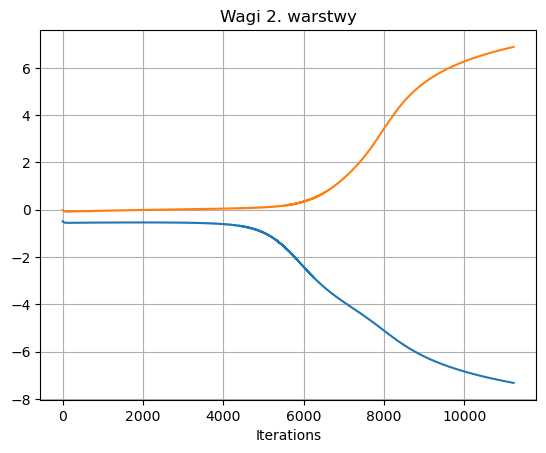

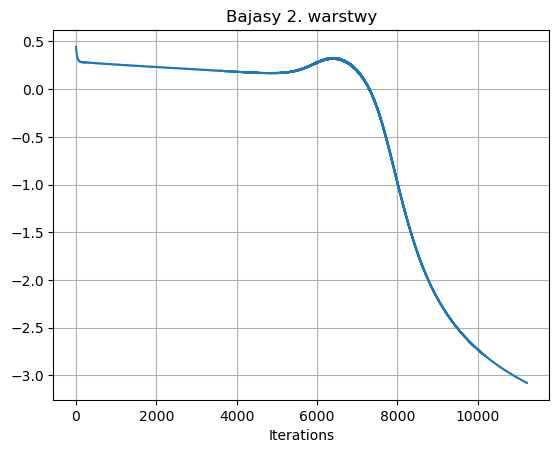

In [14]:
plt.plot([np.concatenate((Ws2[n][0],Ws2[n][1]),axis=0) for n in range(0,len(Ws2))])
plt.xlabel('Iterations')
plt.ylabel('')
plt.title('Wagi 2. warstwy')
plt.grid(True)
plt.show()

plt.plot([bs2[n][0] for n in range(0,len(Ws2))])

plt.xlabel('Iterations')
plt.ylabel('')
plt.title('Bajasy 2. warstwy')
plt.grid(True)
plt.show()